
<span style="background-color:Blue;
             color:white;
             font-size:18px;
             text-align:center;
             border-radius:30px 80px;
             font-weight:bold;
             border:2px solid Blue;
             padding:0px 80px;">🚗 📷 Kalman Filtering on Noisy Camera and Lidar data for Sensor Fusion 🔌 💻
</span>


In this Project we will implement a Kalman filter for sensor fusion of random noisy camera and lidar measurements. The code generates ground truth coordinates, adds random noise to simulate sensor measurements, and then applies the Kalman filter to estimate the true state, the filtered data is plotted alongside the ground truth. It calculates and prints the Root Mean Square Error (RMSE) values, quantifying the accuracy of the filter's estimations. This code demonstrates the application of the Kalman filter for noise reduction and state estimation in sensor data fusion scenarios.

Project Tasks

1. Importing Necessary Libraries
2. Generate Noisy Measurements for Camera and Lidar Data
3. Creating Dataframes
4. Initialise variables for Tracking
5. Prediction Step
6. Update Step
7. Kalman filter Implementation
8. Results
9. Accuracy and Root Mean Square Error (RMSE)


## 1. Importing necessary libraries

In [11]:
# Importing necessary libraries
from random import randrange as noise  # Importing the `randrange` function from the `random` module to generate random noise values
import seaborn as sns          
import numpy as np             
from numpy.linalg import inv     # Importing the `inv` function from `numpy.linalg` module for matrix inversion
import pandas as pd            
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure  
import math                           
%matplotlib inline

## 2. Generate Noisy Measurements for Camera and Lidar Data

In [12]:
# Setting the camera noise and lidar noise values
camera_noise = 10   # Amount of noise that will be added to camera measurements
lidar_noise = 5     # Amount of noise that will be added to Lidar measurements

# Generating a list of timestamps from 0 to 99
time_stamps = [i for i in range(100)]        # sequence of number from 0-99 representing timestamps

# Generating ground truth x and y coordinates
x_gt = [i for i in range(100)]
# Generates sequence of numbers based on Cos Function at each index i in range 0-99
# This creates a Cosine wave pattern with an amplitude of 20 and a vertical offset of 50
y_gt = [math.cos(i/10)*20 + 50 for i in range(100)]   

# Generates noisy measurements for camera and lidar data by adding random noise to the ground truth x and y coordinates. 
# The `camera_noise` and `lidar_noise` values determine the range of the random noise added to the measurements.
# Adding camera noise to each element in x_gt and y_gt coordinates
x_camera = [i + noise(-camera_noise, camera_noise) for i in x_gt]
y_camera = [i + noise(-camera_noise, camera_noise) for i in y_gt]

# Adding lidar noise to x_gt and y_gt coordinates
x_lidar = [i + noise(-lidar_noise, lidar_noise) for i in x_gt]
y_lidar = [i + noise(-lidar_noise, lidar_noise) for i in y_gt]



## 3. Creating Dataframes

In [13]:
def plot(x_gt, y_gt, x1, y1, x2, y2, label_1='label_1', label_2='label_2', title='Title'):
    # Creating a dataframe with x_gt, x1, x2 as columns
    x_data = pd.DataFrame(zip(x_gt, x1, x2), columns=['x_gt', 'x_' + label_1, 'x_' + label_2]) 
    
    # Creating a dataframe with y_gt, y1, y2 as columns
    y_data = pd.DataFrame(zip(y_gt, y1, y2), columns=['y_gt', 'y_' + label_1, 'y_' + label_2]) 

    # Creating a figure with two subplots
    fig, ax = plt.subplots(1, 2, figsize=(20, 6))

    # Plotting the x_data dataframe on the first subplot
    sns.lineplot(data=x_data, ax=ax[0])
    # Plotting the y_data dataframe on the second subplot
    sns.lineplot(data=y_data, ax=ax[1])

    # Setting the labels for the x-axis and y-axis of both subplots
    ax[0].set(xlabel='time', ylabel='x_pos')
    ax[1].set(xlabel='time', ylabel='y_pos')
    # Setting the y-axis limits for both subplots
    plt.ylim(0, 100)
    # Setting the title for the figure
    fig.suptitle(title, fontsize=16)

    # Displaying the figure
    fig.show()

C:\Users\Guptas\AppData\Local\Temp\ipykernel_12784\3865343484.py:25: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


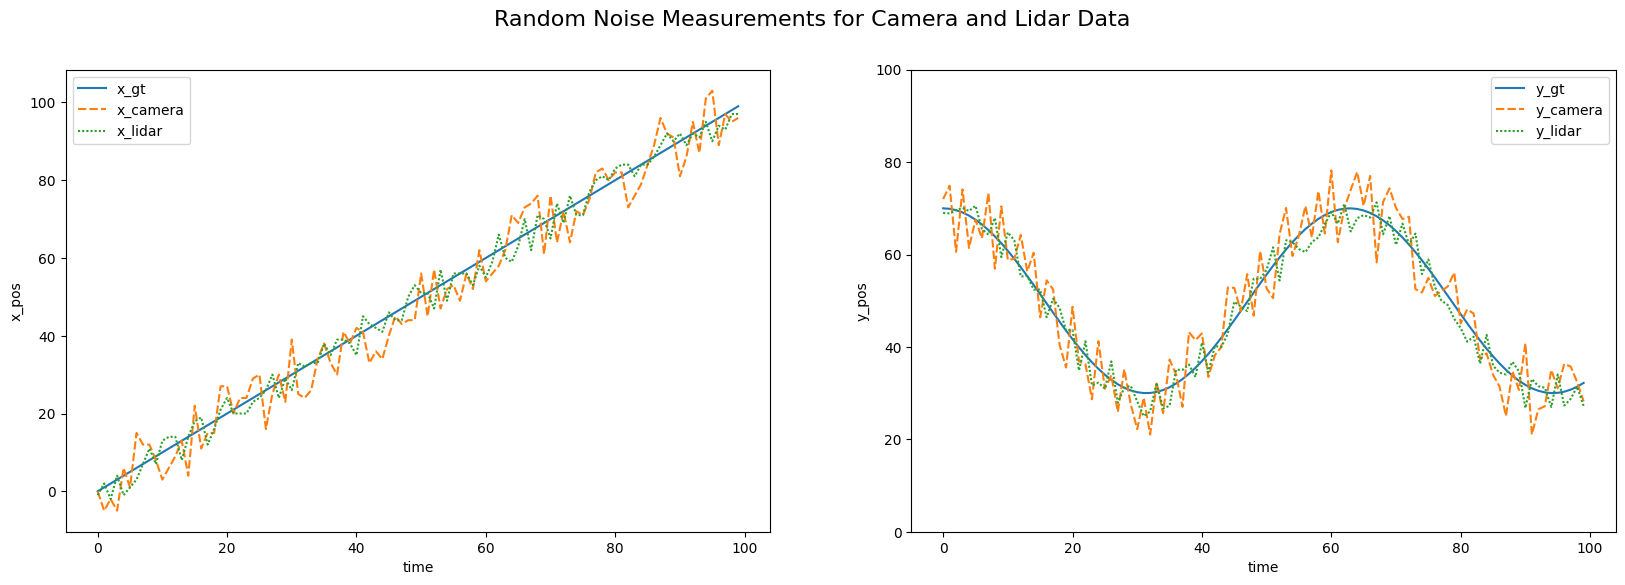

In [14]:
# Calling the previously defined plot function with specific arguments
plot(x_gt, y_gt, x_camera, y_camera, x_lidar, y_lidar, label_1='camera', label_2='lidar', title='Random Noise Measurements for Camera and Lidar Data ')


## 4. Initialise variables for Tracking

In [15]:
# Function to initialize variables
def initialise_variables():
    prv_time = 0  # Variable to store the previous time

    # Initializing state vector X with initial camera position
    X = np.array([[x_camera[0]], [y_camera[0]], [0], [0]])

    # Initializing covariance matrix P 4X4 with initial values
    P = np.array([[10, 0, 0, 0],
                [0, 10, 0, 0],
                [0, 0, 1000, 0],
                [0, 0, 0, 1000]])

    # State transition matrix A 4X4
    A = np.array([[1.0, 0, 1.0, 0],
                [0, 1.0, 0, 1.0],
                [0, 0, 1.0, 0],
                [0, 0, 0, 1.0]])

    # Measurement matrix H 2X4
    H = np.array([[1.0, 0, 0, 0],
                [0, 1.0, 0, 0]])

    # Identity matrix I 4X4
    I = np.identity(4)

    # Zero measurement vector Z 2X1
    Z = np.zeros([2, 1])

    # Measurement noise covariance matrix R 2X2 represents uncertainity in the measurements 
    # Look into initializing these values
    R = np.array([[10, 0],
                [0, 10]])  # Measurement noise covariance matrix
    noise_ax = 0.005  # Acceleration noise in x direction
    noise_ay = 0.005  # Acceleration noise in y direction

    # Zero process covariance matrix Q 4X4
    Q = np.zeros([4, 4])

    return X, P, A, H, I, Z, Q, prv_time


## 5. Prediction step

In [16]:
# The predict() function helps in predicting the future state and reducing the uncertainty in the state 
# estimation by incorporating the process model and process noise
# X state vector representing the current state estimation
# P Covariance matrix representing the uncertainty in the state estimation
# Q Process covariance matrix representing the uncertainty in the state estimation
# A State transition matrix relating the current state to the next state
def predict(X, P, Q, A):
    # Predict the next state using the state transition matrix A
    X = np.matmul(A, X)     # multiply thr state transition matrix A with the current state vector X. Result assigned back to X

    # Transpose of A
    At = np.transpose(A)

    # Update the covariance matrix P using the predicted state and process noise Q
    # Covariance matrix P is updated by multiplying A with the Product of P and 
    # Transpose of State Transition Matrix A, and then adding the process noise covariance matrix Q
    P = np.add(np.matmul(A, np.matmul(P, At)), Q)  

    # Return the predicted state and updated covariance matrix
    return X, P


## 6. Update Step

In [17]:
# The update() function helps in incorporating the measured data into the state estimation process,
# adjusting the state estimate based on the measurement and reducing the the uncertainity in the state estimate
# Z Measurement vector representing the observed values
# X State vector representing the current state estimation
# P Covariance matrix representing the uncertainty in the state estimation
# H Measurement matrix relating the state to the measurement
# R Measurment noise covariance matrix representing the uncertainty in the measurement model
# I Identity matrix
def update(Z, X, P, H, R, I):
    # Calculate the innovation or measurement residual
    Y = np.subtract(Z, np.matmul(H, X))

    # Transpose of H
    Ht = np.transpose(H)

    # Calculate the innovation covariance matrix S
    S = np.add(np.matmul(H, np.matmul(P, Ht)), R)

    # Calculate the Kalman gain K
    K = np.matmul(P, Ht)
    Si = inv(S)
    K = np.matmul(K, Si)
    
    # Update state and covariance matrices using Kalman gain
    X = np.add(X, np.matmul(K, Y))
    P = np.matmul(np.subtract(I ,np.matmul(K, H)), P)

    # Return updated state and covariance matrices
    return X, P


## 7. Kalman filter Implementation

In [18]:
# The `kalman_filter()` function applies the Kalman filter algorithm to the given sensor measurements,
# incorporating system dynamics, noise models, and update steps to provide a robust estimation of the true state.
def kalman_filter(x_measurements, y_measurements, measurement_time_stamps, R_value=10, noise_ax=0.005, noise_ay=0.005):
    # Initialize variables
    X, P, A, H, I, Z, Q, prv_time = initialise_variables()

    # Measurement noise covariance matrix 2X2 filled with R_value given as input
    R = np.array([[R_value, 0],
                 [0, R_value]])

    x_filtered = []  # Filtered x-coordinate values
    y_filtered = []  # Filtered y-coordinate values

    # Filtering Loop 
    # Iterate through sensor data using the a loop from 1 to length of x_measurements
    # Each iteration processes a new measurement point
    for i in range (1, len(x_measurements)):
        # The x and y values of the new measurement are extracted into the new_measurement list 
        new_measurement = [x_measurements[i], y_measurements[i]]

        # Time step calculation
        cur_time = measurement_time_stamps[i]
        # The time difference dt between the current measurement time stamp and the previous measurement time stamp is calculated
        dt = cur_time - prv_time
        prv_time = cur_time

        dt_2 = dt * dt
        dt_3 = dt_2 * dt
        dt_4 = dt_3 * dt

        # Update of matrix A with dt value
        # The element of matrix A are updated to incorporate the value of dt for modeling the system dynamics
        A[0][2] = dt
        A[1][3] = dt

        # Update of Q matrix
        # The elements of the process noise covariance matrix Q are updated based on dt and noise magnitudes 
        # along the x noise_ax and y nise_ay axes respectively 
        Q[0][0] = dt_4/4*noise_ax
        Q[0][2] = dt_3/2*noise_ax
        Q[1][1] = dt_4/4*noise_ay
        Q[1][3] = dt_3/2*noise_ay
        Q[2][0] = dt_3/2*noise_ax
        Q[2][2] = dt_2*noise_ax
        Q[3][1] = dt_3/2*noise_ay
        Q[3][3] = dt_2*noise_ay

        # Update sensor readings
        # The measurement vector Z is updated with current x and y coordinate values
        Z[0][0] = new_measurement[0]
        Z[1][0] = new_measurement[1]

        # Perform prediction step
        #The `predict()` function is called with the state estimation (`X`), covariance matrix (`P`), process noise covariance matrix (`Q`), and system matrix (`A`) as inputs.
        #The `predict()` function returns the updated state estimation and covariance matrix, which are assigned back to `X` and `P`.
        X, P = predict(X, P, Q, A)

        # Perform update step
        # The `update()` function is called with the updated measurement vector (`Z`), state estimation (`X`), covariance matrix (`P`), measurement matrix (`H`), measurement noise covariance matrix (`R`), and identity matrix (`I`).
        # The `update()` function returns the updated state estimation and covariance matrix, which are assigned back to `X` and `P`.
        X, P = update(Z, X, P, H, R, I)

        # Append filtered x and y values to respective lists
        #The x and y values from the updated state estimation (`X`) are extracted and appended to the `x_filtered` and `y_filtered` lists respectively.
        x_filtered.append(X[0][0])
        y_filtered.append(X[1][0])

    #The function returns the lists `x_filtered` and `y_filtered`, which contain the filtered x and y coordinate values.
    return x_filtered, y_filtered


## 8. Results

C:\Users\Guptas\AppData\Local\Temp\ipykernel_12784\3865343484.py:25: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
C:\Users\Guptas\AppData\Local\Temp\ipykernel_12784\3865343484.py:25: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


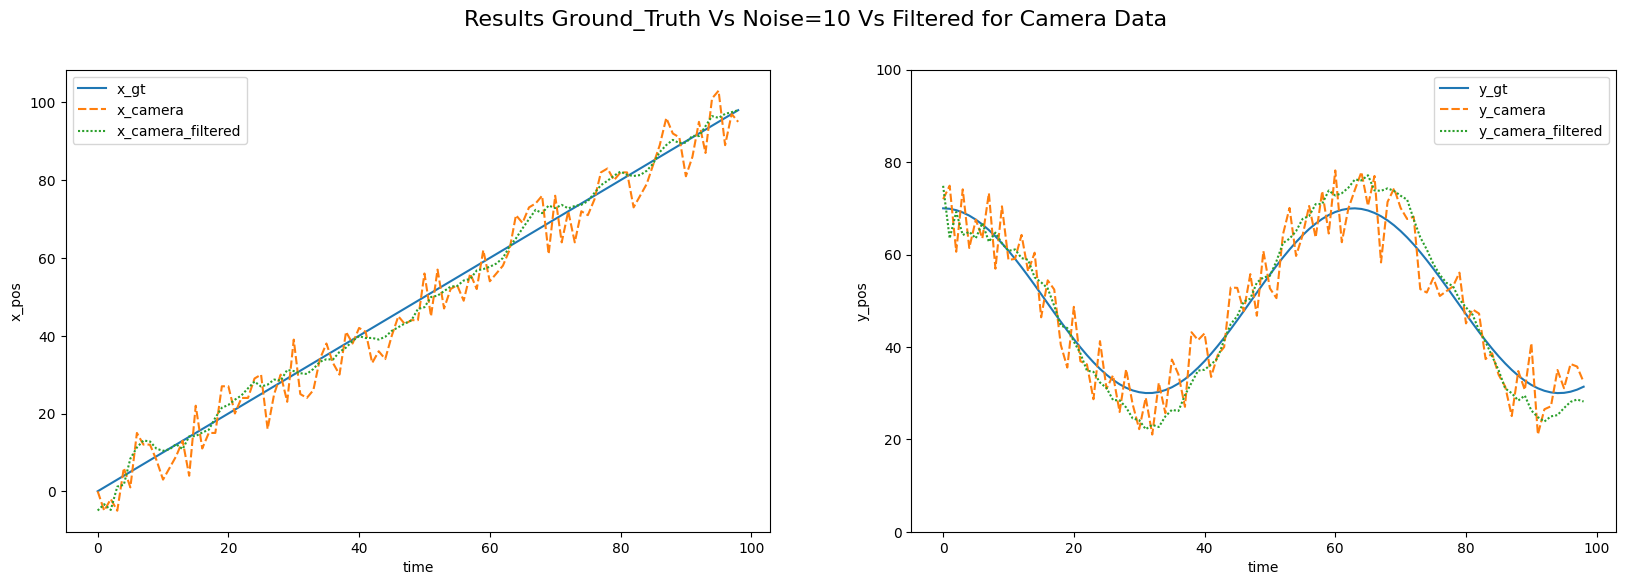

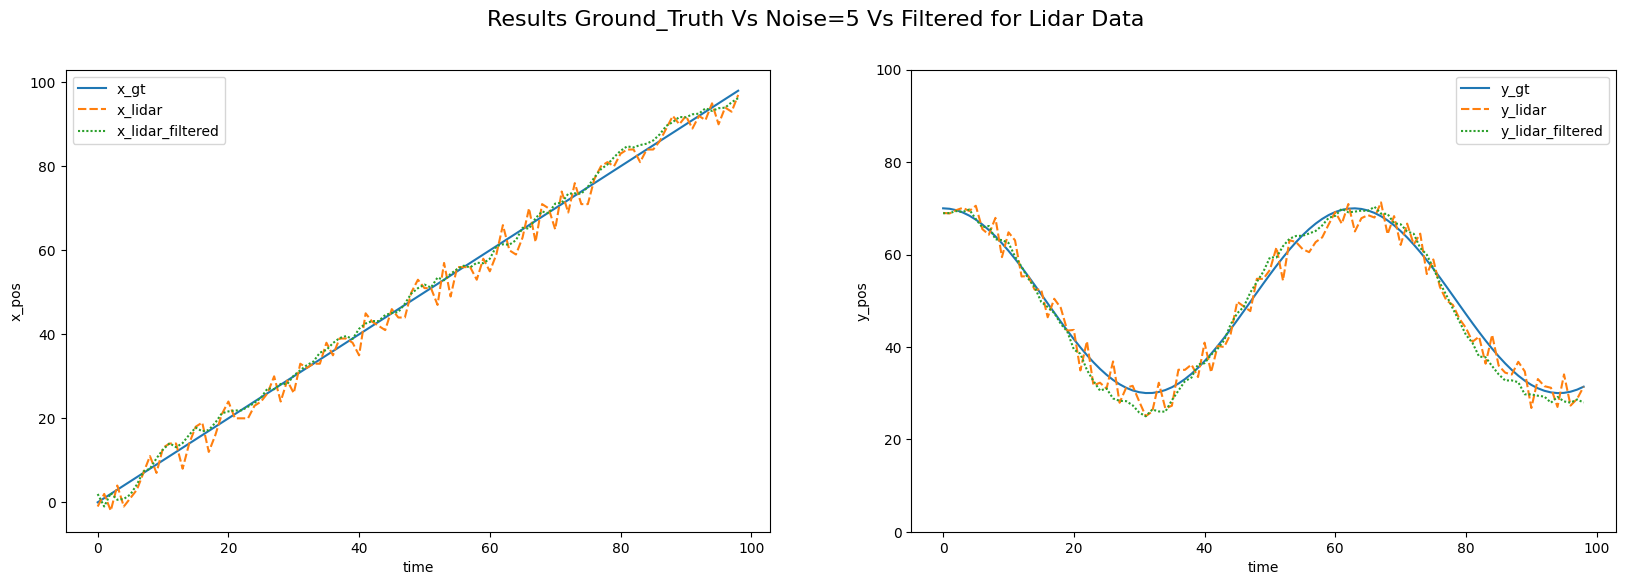

In [19]:
# Applying Kalman filter to camera measurements
x_filtered_camera, y_filtered_camera = kalman_filter(x_camera, y_camera, time_stamps, 10, 0.005, 0.01)

# Applying Kalman filter to lidar measurements
x_filtered_lidar, y_filtered_lidar = kalman_filter(x_lidar, y_lidar, time_stamps, 10, 0.05, 0.05)

# Plotting the ground truth, camera measurements, and filtered camera data
plot(x_gt, y_gt, x_camera, y_camera, x_filtered_camera, y_filtered_camera, label_1='camera', label_2='camera_filtered', title='Results Ground_Truth Vs Noise=10 Vs Filtered for Camera Data')

# Plotting the ground truth, lidar measurements, and filtered lidar data
plot(x_gt, y_gt, x_lidar, y_lidar, x_filtered_lidar, y_filtered_lidar, label_1='lidar', label_2='lidar_filtered', title='Results Ground_Truth Vs Noise=5 Vs Filtered for Lidar Data')


## 9. Accuracy and Root Mean Square Error (RMSE)

In [20]:
# Calculate the root mean square error (RMSE) for the x-coordinate of the camera data
x_rmse_camera = round(sum([(i[0] - i[1]) ** 2 for i in zip(x_filtered_camera, x_gt[1:])])/len(x_filtered_camera), 4)

# Calculate the root mean square error (RMSE) for the y-coordinate of the camera data
y_rmse_camera = round(sum([(i[0] - i[1]) ** 2 for i in zip(y_filtered_camera, y_gt[1:])])/len(y_filtered_camera), 4)

# Calculate the root mean square error (RMSE) for the x-coordinate of the lidar data
x_rmse_lidar = round(sum([(i[0] - i[1]) ** 2 for i in zip(x_filtered_lidar, x_gt[1:])])/len(x_filtered_lidar), 4)

# Calculate the root mean square error (RMSE) for the y-coordinate of the lidar data
y_rmse_lidar = round(sum([(i[0] - i[1]) ** 2 for i in zip(y_filtered_lidar, y_gt[1:])])/len(y_filtered_lidar), 4)

# Print the RMSE values for the x-coordinate of the camera and lidar data
print('x_rmse_camera: ', x_rmse_camera)
print('y_rmse_camera: ', y_rmse_camera)

# Print the RMSE values for the x-coordinate of the camera and lidar data
print('x_rmse_lidar:  ', x_rmse_lidar)
print('y_rmse_lidar:  ', y_rmse_lidar)


x_rmse_camera:  6.9985
y_rmse_camera:  18.188
x_rmse_lidar:   2.3123
y_rmse_lidar:   4.6571


<div
<span style="background-color:Blue;
             color:white;
             font-size:19px;
             text-align:center;
             font-weight:bold;
             border:0px solid Blue;
             border-radius:30px 80px;
             font-weight:bold;
             padding:0px 80px;"> Thank You, for your Time 😃
</span>
</div>